In [14]:
import json 
import os
import datetime
import sys

In [15]:
import os

def common_path(paths, variable_list):
    split_paths = [path.strip(os.sep).split(os.sep) for path in paths]
    min_len = min(len(parts) for parts in split_paths)
    result = []
    
    for i in range(min_len):
        ith_parts = [parts[i] for parts in split_paths]
        if all(part == ith_parts[0] for part in ith_parts):
            result.append(ith_parts[0])
        else:
            unique_parts = set(ith_parts)
            variable_dir = True if set(variable_list) == set(unique_parts) else False
            version_dir = True if all(d.startswith('v') for d in ith_parts) else False

            print(ith_parts)
            print(version_dir)

            if variable_dir:
                result.append("%(variable)")
            elif version_dir:
                result.append("latest")
            else:
                result.append('*')

                


    if len(set(len(parts) for parts in split_paths)) > 1:
        result.append('*')

    outpath = os.sep + os.path.join(*result)
    if not outpath.endswith('/'): 
        outpath += '/' # outpath ends with '*'
    return outpath

def common_filepath(files, variable_list):
    split_files = [file.strip('_').split('_') for file in files]
    min_len = min(len(parts) for parts in split_files)
    result = []

    # print(min_len)

    for i in range(min_len):
        ith_parts = [parts[i] for parts in split_files]
        if all(part == ith_parts[0] for part in ith_parts):
            result.append(ith_parts[0])
        else:
            unique_parts = set(ith_parts)
            varname = True if set(variable_list) == set(unique_parts) else False
            if varname:
                result.append("%(variable)")
            else:
                result.append('*')
    if len(set(len(parts) for parts in split_files)) > 1:
        result.append('*')
    return ("_").join(result)

In [16]:
fV = "/global/cfs/projectdirs/m4581/obs4MIPs/catalogue/obs4MIPs_PCMDI_day_byVar_catalogue_v20251023.json"
fS = "/global/cfs/projectdirs/m4581/obs4MIPs/catalogue/obs4MIPs_PCMDI_day_bySource_catalogue_v20251023.json"

In [17]:
def read_json_byVar(f, variable_list = ["pr", "tasmax", "tasmin", "tas"], source_list = [], outdir = "/global/homes/j/jsgoodni/pcmdi_metrics/pcmdi_metrics/drcdm/param/default/", dry_run = True): 
    """ 
    Create DRCDP parameter files for each variable in variable_list. 

    Input
     - f: JSON file path 
     - variable_list: Desired variables
     - source_list: Data sources. Must be keys within JSON file data
     - outdir: parameter file directory. Default "./" (run within the parameter file location)

    Out
     - Writes 1 parameter file per variable in variable_list, if data sources are found.

    """

    with open(f) as jfile: 
        data = json.load(jfile)

    byVar = False 
    bySource = False 

    if "obs4MIPs" in f: 
        realization = "obs"
    else:
        realization = "r1i1i1p1"

    data_keys = list(data.keys())

    # Determine if the JSON is organized by variable or by source
    if len(list(set(variable_list) & set(data_keys))) != 0: 
        print("[JSON File]: Organized by Variable detected")
        byVar = True
    else: 
        print("[JSON File]: Organized by Source detected")
        bySource = True

    def run_cmd(cmd): 
        print(f"[Running] {cmd}")
        os.system(cmd)


    run_file_list = []

    for variable in variable_list: 
        replacement_dict = { 
            "$(var_list)": f"[{variable}]", 
        }

        if variable not in data_keys:
            continue
        else: 
            print(f"[Found Sources for]: {variable}")
            sourceDict = data[variable]
            sources = list(sourceDict.keys())
            missing_sources = [] 

            if len(source_list) != 0:
                sources = [source for source in sources if source in source_list]
                missing_sources = [source for source in source_list if source not in sources]

            for source in sources: 
                print(f"\t{source}")
                # print(sourceDict[source])
                if "pcmdi-internal-template" not in sourceDict[source]:
                    continue 
                path_template = sourceDict[source]['pcmdi-internal-template']
                file_template = path_template.split('/')[-1]
                dir_template = path_template.replace(file_template, "") # replace the filename template with "" to just get the directory

                period = sourceDict[source]["period"]
                start_year = int(period.split("-")[0][0:4])
                if start_year < 1950: 
                    start_year = 1950
                end_year = int(period.split("-")[-1][0:4])  

                print(f"\t[DIRECTORY]: {dir_template}")
                print(f"\t[FILE(S)]: {file_template}")
                print(f"\t[PERIOD]: {period}")
                print('')

                if dry_run: 
                    continue
                
            
                # Create the outfile name
                outf = f.split('/')[-1].replace(".json", ".py")

                outf = outf.replace("byVar", f"{source}_{variable}")
                outf = outf.replace("_catalogue_", "_")
                    
                cmd = f"scp {outdir}.default_param.py {outdir}{outf}" 
                run_cmd(cmd)

                cmd = f"sed -i \"s/%(source_name)/{source}/g\" {outdir}{outf}"  
                run_cmd(cmd)

                cmd = f"sed -i 's/%(varname)/{variable}/g' {outdir}{outf}"
                run_cmd(cmd)

                cmd = f"sed -i \"s#%(realization)#{realization}#g\" {outdir}{outf}"
                run_cmd(cmd)
                
                cmd = f"sed -i \"s#%(path_dir)#{dir_template}#g\" {outdir}{outf}"
                run_cmd(cmd)

                cmd = f"sed -i \"s#%(file_path)#{file_template}#g\" {outdir}{outf}"
                run_cmd(cmd)

                cmd = f"sed -i \"s#'%(start_year)'#{start_year}#g\" {outdir}{outf}"
                run_cmd(cmd)

                cmd = f"sed -i \"s#'%(end_year)'#{end_year}#g\" {outdir}{outf}"
                run_cmd(cmd)

                print(f'[Created DRCDP Parameter File]: {outf}')

                run_file_list.append(outf)

                print('\n')

            
            
            if len(missing_sources) > 0: 
                print("[NOT FOUND]")
                for source in missing_sources: 
                    print(f"\t{source}")

    today = datetime.date.today().strftime("%Y%m%d")
    run_name = f"run_all_{today}.sh"
    drcdm_diri = "/global/homes/j/jsgoodni/pcmdi_metrics/pcmdi_metrics/drcdm/"


    if not dry_run: 
        with open(f"{drcdm_diri}param/default/{run_name}", "w") as f: 
            f.write("#!/bin/bash\n\n")
            for param_file in run_file_list: 
                f.write(f"python {drcdm_diri}drcdm_driver2.py -p {param_file}\n")

        
        print(f"[Created Run File] {run_name}")

    return data

In [18]:
def read_json_bySource(f, variable_list = ["pr", "tasmax", "tasmin", "tas"], source_list = [], outdir = "/global/homes/j/jsgoodni/pcmdi_metrics/pcmdi_metrics/drcdm/param/default/", dry_run = True): 
    """ 
    Create DRCDP parameter files for each variable in variable_list. 

    Input
     - f: JSON file path 
     - variable_list: Desired variables
     - source_list: Data sources. Must be keys within JSON file data
     - outdir: parameter file directory. Default "./" (run within the parameter file location)

    Out
     - Writes 1 parameter file per variable in variable_list, if data sources are found.

    """

    with open(f) as jfile: 
        data = json.load(jfile)

    if "obs4MIPs" in f: 
        realization = "obs"
    else:
        realization = "r1i1i1p1"

    sources = list(data.keys())

    if len(source_list) == 0: 
        source_list = sources
    else:
        source_list = [source for source in sources if source in source_list]

    def run_cmd(cmd): 
        # print(f"[Running] {cmd}")
        os.system(cmd)

    run_file_list = []

    for source in source_list: 
        print(f"[Found Variables for]: {source}")
        varDict = data[source]
        variables = list(varDict.keys())
        missing_vars = [] 

        if len(variable_list) != 0:
            variables = [variable for variable in variables if variable in variable_list]
            missing_variables = [variable for variable in variable_list if variable not in variables]

        # print(variables)
        # print(missing_variables)

        directory_list = []
        file_list = []
        start_years = []
        end_years = []

        for variable in variables: 
            print(f"\t{variable}")
            # print(sourceDict[source])
            if "pcmdi-internal-template" not in varDict[variable]:
                continue 
            path_template = varDict[variable]['pcmdi-internal-template']
            file_template = path_template.split('/')[-1]
            dir_template = path_template.replace(file_template, "") # replace the filename template with "" to just get the directory

            directory_list.append(dir_template)
            file_list.append(file_template)

            period = varDict[variable]["period"]
            start_year = int(period.split("-")[0][0:4])
            if start_year < 1950: 
                start_year = 1950
            end_year = int(period.split("-")[-1][0:4])  

            print(f"\t[DIRECTORY]: {dir_template}")
            print(f"\t[FILE(S)]: {file_template}")
            print(f"\t[PERIOD]: {period}")
            print('')

            start_years.append(start_year)
            end_years.append(end_year)

        if dry_run: 
            continue
        
        fullDirTemplate = common_path(directory_list, variable_list=variables)
        fullPathTemplate = common_filepath(file_list, variable_list=variables)

        fullStartYear = max(start_years)
        fullEndYear = min(end_years)
        
        # Create the outfile name
        outf = f.split('/')[-1].replace(".json", ".py")

        print(outf)

        outf = outf.replace("_bySource_", f"_{source}_")
        outf = outf.replace("_catalogue_", "_")
            
        cmd = f"scp {outdir}.default_param.py {outdir}{outf}" 
        run_cmd(cmd)

        cmd = f"sed -i \"s/%(source_name)/{source}/g\" {outdir}{outf}"  
        run_cmd(cmd)

        cmd = f"sed -i \"s/vars = \[\\\"%(varname)\\\"\\]/vars = {str(variables)}/g\" {outdir}{outf}"
        run_cmd(cmd)

        cmd = f"sed -i \"s#%(realization)#{realization}#g\" {outdir}{outf}"
        run_cmd(cmd)
        
        cmd = f"sed -i \"s#%(path_dir)#{fullDirTemplate}#g\" {outdir}{outf}"
        run_cmd(cmd)

        cmd = f"sed -i \"s#%(file_path)#{fullPathTemplate}#g\" {outdir}{outf}"
        run_cmd(cmd)

        cmd = f"sed -i \"s#'%(start_year)'#{fullStartYear}#g\" {outdir}{outf}"
        run_cmd(cmd)

        cmd = f"sed -i \"s#'%(end_year)'#{fullEndYear}#g\" {outdir}{outf}"
        run_cmd(cmd)

        print(f'[Created DRCDP Parameter File]: {outf}')

        run_file_list.append(outf)

        print('\n')
        
        if len(missing_variables) > 0: 
            print("[NOT FOUND]")
            for variable in missing_variables: 
                print(f"\t{variable}")

    today = datetime.date.today().strftime("%Y%m%d")
    run_name = f"run_all_{today}.sh"
    drcdm_diri = "/global/homes/j/jsgoodni/pcmdi_metrics/pcmdi_metrics/drcdm/"


    if not dry_run: 
        with open(f"{drcdm_diri}param/default/{run_name}", "w") as f: 
            f.write("#!/bin/bash\n\n")
            for param_file in run_file_list: 
                f.write(f"python {drcdm_diri}drcdm_driver2.py -p {param_file}\n")

        
        print(f"[Created Run File] {run_name}")

    return

In [19]:
read_json_bySource(fS, source_list=["livneh-1-0", "ERA-5"], dry_run=False)

[Found Variables for]: ERA-5
	pr
	[DIRECTORY]: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/ECMWF/ERA-5/day/pr/1x1/v20210824/
	[FILE(S)]: pr_day_ERA-5_PCMDIFROGS_1x1_19790101-20181231.nc
	[PERIOD]: 19790101-20181231

obs4MIPs_PCMDI_day_bySource_catalogue_v20251023.py
[Created DRCDP Parameter File]: obs4MIPs_PCMDI_day_ERA-5_v20251023.py


[NOT FOUND]
	tasmax
	tasmin
	tas
[Found Variables for]: livneh-1-0
	pr
	[DIRECTORY]: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/NOAA-ESRL-PSD/livneh-1-0/day/pr/gn/v20230613/
	[FILE(S)]: pr_day_livneh-1-0_PCMDI_gn_*.nc
	[PERIOD]: 19150101-20111231

	tasmax
	[DIRECTORY]: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/NOAA-ESRL-PSD/livneh-1-0/day/tasmax/gn/v20251022/
	[FILE(S)]: tasmax_day_livneh-1-0_PCMDI_gn_*.nc
	[PERIOD]: 19150101-20181231

	tasmin
	[DIRECTORY]: /global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/NOAA-ESRL-PSD/livneh-1-0/day/tasmin/gn/v20230613/
	[FILE(S)]: tasmin_day_livneh-1-0_PCMDI_gn_*.nc
	[PERIOD]: 1915010

In [24]:
# data = read_json_byVar(f, 
#                  variable_list=["tasmax", "tasmin", "pr"], 
#                  source_list=["nClimGrid-Daily-1-0", "ERA-5", "livneh-1-0", "CMORPH-1-0", "GPCP-1-3"], 
#                  dry_run = True
#                  )

In [3]:
import xarray as xr
ds = xr.open_dataset("/global/cfs/projectdirs/m4581/obs4MIPs/obs4MIPs_LLNL/NOAA-ESRL-PSD/livneh-1-0/day/tasmax/gn/v20230613/tasmax_day_livneh-1-0_PCMDI_gn_20120101-20121231.nc")

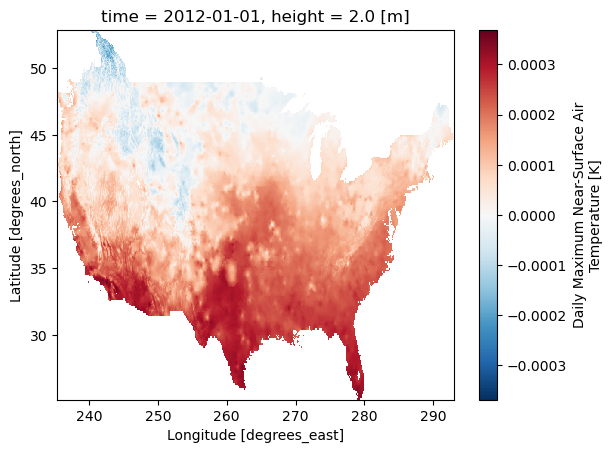

In [7]:
ds["tasmax"].isel(time = 0).plot()

In [19]:
t1 = (ds["tasmax"]*3600.*24 + 273.15).isel(time = 180)# .plot()

In [20]:
ds_test = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/Livneh_Unsplit/livneh_lusu_2020_temp_and_wind.2021-05-02.2012.nc")

/global/homes/j/jsgoodni/miniforge3/envs/drcdm/lib/python3.10/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'Tmax' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/global/homes/j/jsgoodni/miniforge3/envs/drcdm/lib/python3.10/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'Tmin' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/global/homes/j/jsgoodni/miniforge3/envs/drcdm/lib/python3.10/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'Wind' has multiple fill values {np.float32(1e+20), np.float64(1e+20)} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [22]:
t2 = ds_test["Tmax"].isel(time = 180)

In [25]:
(t2 - t1)

ValueError: dimensions ('lat', 'lon') must have the same length as the number of data dimensions, ndim=3

In [26]:
t2

<xarray.DataArray 'Tmax' (lat: 444, lon: 922)> Size: 2MB
[409368 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 7kB -124.6 -124.5 -124.5 ... -67.16 -67.09 -67.03
  * lat      (lat) float64 4kB 25.16 25.22 25.28 25.34 ... 52.72 52.78 52.84
    time     datetime64[ns] 8B 2012-06-29
Attributes:
    units:      degC
    long_name:  Maximum daily air temperature

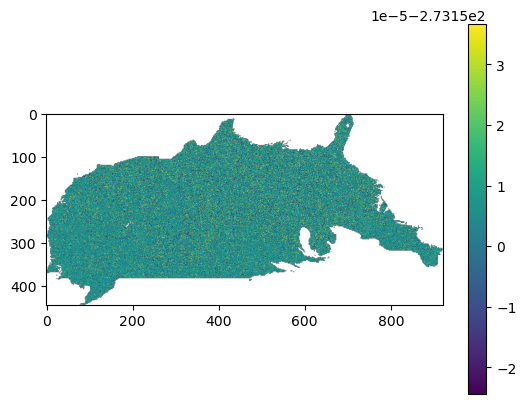

In [30]:
import matplotlib.pyplot as plt
plt.imshow(t2.data - t1.data)
plt.colorbar()

In [2]:
import xarray as xr
ds = xr.open_dataset("/global/cfs/projectdirs/m3522/datalake/JRA3Q/anl_surf/194811/jra3q.anl_surf.0_0_0.tmp2m-hgt-an-gauss.1948110100_1948113018.nc")

In [3]:
ds

<xarray.Dataset> Size: 221MB
Dimensions:                                             (time: 120, lat: 480,
                                                         lon: 960)
Coordinates:
  * time                                                (time) datetime64[ns] 960B ...
  * lat                                                 (lat) float64 4kB 89....
  * lon                                                 (lon) float64 8kB 0.0...
Data variables:
    utc_date_int                                        (time) int32 480B ...
    utc_date_str                                        (time) <U23 11kB ...
    weight                                              (lat) float64 4kB ...
    original_number_of_grid_points_per_latitude_circle  (lat) int32 2kB ...
    tmp2m-hgt-an-gauss                                  (time, lat, lon) float32 221MB ...
Attributes: (12/91)
    jma_data_provider:                                  Japan Meteorological ...
    jma_data_provider_url:                              https://www.jma.go.jp...
    jma_data_provider_address:                          3-6-9 Toranomon, Mina...
    jma_data_provider_email:                            <jra@met.kishou.go.jp>
    jma_data_title:                                     Japanese Reanalysis f...
    jma_data_abstract:                                  JMA is currently cond...
    ...                                                 ...
    rda_github_software_repository:                     https://github.com/NC...
    rda_software_license:                               MIT License. Copyrigh...
    rda_nsf_statement:                                  This material is base...
    rda_alias_formatted_ncdump_tcshrc:                  alias ncdumpf "ncdump...
    rda_function_formatted_ncdump_bashrc:               ncdumpf(){ file=$2; w...
    rda_related_datasets:                               ds640.1, Near Real-Ti...